## Goal: Check various hypothesis

In [ ]:
import pandas as pd
import pypsa
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde"

### Check 1: Compare Total System Cost with / without network

In [ ]:
# Total system cost
runs = ["h2network_true", "h2network_false", "test_subworkflow"]

stats = pd.DataFrame(columns=runs, index=["H2", "AC", "total costs"])

for run in runs:
    metrics = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/metrics.csv", header=[0,1,2,3,4,5,6], index_col=0)
    prices = pd.read_csv(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/csvs/prices.csv", header=[0,1,2,3,4,5,6], index_col=0)

    stats.loc["H2", run] = prices.loc["H2"].values[0]
    stats.loc["AC", run] = prices.loc["AC"].values[0]
    stats.loc["total costs", run] = metrics.loc["total costs"].values[0]/1e9 # in B€


In [ ]:
stats.head()

### Check 2: Hydrogen & battery storage of single run but e_inital modification

In [ ]:
run = "h2network_true_3h"

In [ ]:

export_only = prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved_einitial0.nc"
mar_only =prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_0export.nc"
mar_es_export =prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export.nc"
n = pypsa.Network(mar_es_export)

In [ ]:
n_old = pypsa.Network(mar_es_export)
n_new = pypsa.Network(prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_3H_2030_0.071_DF_120export_solved.nc")

In [ ]:
def get_export_supply(n):
    return (n.links_t.p1.loc[:, n.links_t.p1.columns.str.contains("export")].sum(axis=1)*(-1))


In [ ]:
# Show storage levels and charging of 200 time steps
n_old.stores_t.e["H2 export store"].plot() #[2000:2200].plot()
n_new.stores_t.e["H2 export store"].plot() #[2000:2200].plot()

export_supply_new = get_export_supply(n_new)

In [ ]:
#export_supply_old[2000:2400].plot()
export_supply_new[2000:2400].plot()

In [ ]:
n_old.objective/1e6

In [ ]:
n_new.objective/1e6

In [ ]:
n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.stores[n.stores.index.str.contains("battery")].head()

In [ ]:
n.generators.p_nom_opt.sort_values(ascending=False)[0:10]

In [ ]:
n.links_t.p0.loc[:, n.links.index.str.contains("battery")].sum().sort_values(ascending=False)[0:10] #.head()

In [ ]:
# Show capacities and nodes of top batteries
n.stores[(n.stores.carrier=="battery")].e_nom_opt.sort_values(ascending=False) # head()

Export hydrogen storage

In [ ]:
n.stores[n.stores.bus == "H2 export bus"].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
n.loads

In [ ]:
# Show storage levels and charging of 200 time steps
import matplotlib.pyplot as plt
def plot_export_store(n, time_min = 0, time_max = 10):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()

    ax.plot(n.stores_t.p["H2 export store"][time_min:time_max]/1e3) # in GW
    ax.plot(n.loads_t.p["H2 export load"][time_min:time_max]/1e3) # in GW
    ax.plot(get_export_supply(n)[time_min:time_max]/1e3) # in GW

    storage_level = n.stores_t.e["H2 export store"][time_min:time_max]/ 1e3 # in GWh
    ax2.plot(storage_level, color="grey", linestyle="--")

    ax.legend(["store charging", "export load", "supply (from system)"], loc='upper right')
    ax2.legend(["store level (from n.stores_t.e)"], loc='upper left')
    ax2.set_ylabel("Storage level in GWh")
    ax.set_ylabel("Power in GW")
    ax.grid()


In [ ]:
plot_export_store(n, 0, 160)

Retrieve storage sizes across types (MAR ES only, MAR ES export, Export only) within one scenario/run

In [ ]:
# Get storage sizes of hydrogen and battery for all networks
run = "store_standardcosts_6h_ws"
networks = ["export_only", "mar_only", "mar_es_export"]

network_paths = {
        "export_only": prefix +"/resources/export_only/" + run +"/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export_solved.nc",
        "mar_only": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_0export.nc",
        "mar_es_export": prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc",
}


stats = pd.DataFrame(columns=networks, index=["H2_GWh", "Battery_GWh", "H2export_GWh"])

for network in networks:
    
    n = pypsa.Network(network_paths[network])

    stats.loc["H2_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", network] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh

    stats.loc["H2export_GWh", network] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh

In [ ]:
stats.head()

### Check 3: Export store with costs/no costs/no store

Retrieve storage sizes of one type (MAR ES export) of various scenarios/runs

In [132]:
# Get storage sizes of hydrogen and battery for all networks
runs = ["store_nocosts_6h_ws", "store_standardcosts_6h_ws", "store_nostore_6h_ws"]

stats = pd.DataFrame(columns=runs, index=["H2_GWh", "Battery_GWh", "H2export_GWh", "objective_B€"])

for run in runs:
    
    network_path = prefix + "/resources/pypsaearthsec/" + run + "/postnetworks/elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc"

    n = pypsa.Network(network_path)

    stats.loc["H2_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus != "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["Battery_GWh", run] = n.stores[(n.stores.carrier=="battery")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["H2export_GWh", run] = n.stores[(n.stores.carrier=="H2") & (n.stores.bus == "H2 export bus")].e_nom_opt.sum() / 1e3 # in GWh
    stats.loc["objective_B€", run] = n.objective / 1e9 # in B€

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.10_6H_2030_0.071_DF_120export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [133]:
stats.head()

,store_nocosts_6h_ws,store_standardcosts_6h_ws,store_nostore_6h_ws
H2_GWh,30.14973,161.574785,182.908774
Battery_GWh,47.387106,48.441827,48.437268
H2export_GWh,8683.058316,21.335936,0.0
objective_B€,17.078372,18.133305,18.133065


Show timeseries

In [ ]:
export_supply = get_export_supply(n)
export_supply[2000:2400].plot()

KeyError: 'H2 export store'

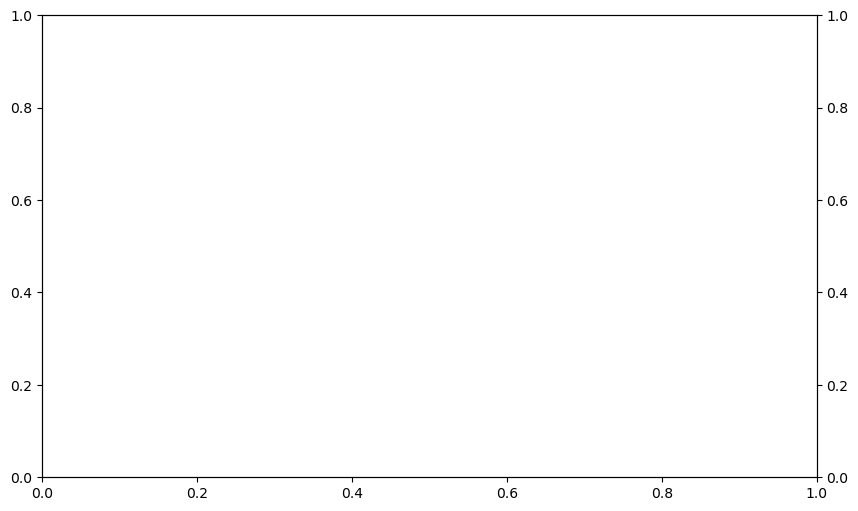

In [134]:
plot_export_store(n, 0, 160)